### Backstory: 
given a specific user, find out more about them: 
where they’re from, 
what things they like/dislike, 
and other data about their background (think of at least 2 more things to determine). 

Note that this should be somewhat automated; I should be able to give you a username and you’ll produce a backstory dataset for them (it may work better with some users than others). Provide a three sample user backstories in your report, written up as a narrative.

In [5]:
user = 'Late_Night_Grumbler'
user2 = 'Lots42'
user3 = 'qkme_transcriber'

#### Loading dataset

In [3]:
# from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import from_json, col
conf = SparkConf().setAppName('FirstSpark2').setMaster('Spark')
sc = SparkContext.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df = sqlContext.read.json("hdfs://orion11:20001/sample_sampled_reddit/")

print(type(df))
print(df.count())
df.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
30926243
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+--------

#### Filtering dataset

In [4]:
df2 = df.filter(
~(df.body.like('[deleted]'))
    & ~(df.body.isNull())
    & ~(df.author.like('[deleted]'))
    & ~(df.author.like('AutoModerator')) 
    & ~(df.author.rlike("[bB][oO][tT]"))

)

print(type(df2))
print(df2.count())
df2.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
27303462
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+--------

#### Adding Comment sentiment column

In [6]:
%%time

# import nltk
# nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

from pyspark.sql import functions as F
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# pattern = "\b[A-Z]+"

def getSentiment(body):
    ss = sid.polarity_scores(body)
    print(ss)
    return ss["compound"]

Score = udf(getSentiment, StringType())
df3 = df2.withColumn('sentiment', Score("body"))

print(type(df3))
print(df3.count())
df3.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
27303462
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+---------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|sentiment|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+-----------

#### Users with most comments

In [7]:
groupedByAuthor = df3.groupBy(df3.author).count().orderBy('count', ascending=False)
groupedByAuthor.show()

+--------------------+-----+
|              author|count|
+--------------------+-----+
|     ImagesOfNetwork| 7325|
|       ModerationLog| 5722|
|         TweetPoster| 5607|
|      MTGCardFetcher| 5495|
|    imgurtranscriber| 3963|
|throwthrowawaytothee| 3814|
| Late_Night_Grumbler| 3129|
|    qkme_transcriber| 3034|
|      TotesMessenger| 2831|
|      User_Simulator| 2248|
|            autotldr| 2217|
|        Franciscouzo| 1981|
|        morbiusgreen| 1962|
|              Lots42| 1953|
|        PornOverlord| 1949|
|         UnluckyLuke| 1800|
|          davidjl123| 1790|
|      atomicimploder| 1778|
|          pixis-4950| 1757|
|                -rix| 1711|
+--------------------+-----+
only showing top 20 rows



#### Filtering data for the given user

In [8]:
df4 = df3.filter(
(df3.author.like(user))
)

print(type(df4))
print(df4.count())
df4.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
3129
+--------+-------------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------+------------+---+------------+---------+
|archived|             author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|subreddit|subreddit_id|ups|user_reports|sentiment|
+--------+-------------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+------------

#### Getting agg of sentiment for a user in all participated subreddits

In [9]:
groupedBysubreddit = df4.groupBy(df4.subreddit)
groupedBysubreddit = groupedBysubreddit.agg({'sentiment':'avg'})

#### Top 5 subreddit they like

In [10]:
pos5 = groupedBysubreddit.orderBy('avg(sentiment)', ascending=False).show(5)

+-----------+------------------+
|  subreddit|    avg(sentiment)|
+-----------+------------------+
|       FLCL|            0.9764|
|       pics|            0.7961|
|     iphone|            0.6808|
|    Scrolls|0.5478666666666666|
|InternetAMA|            0.4824|
+-----------+------------------+
only showing top 5 rows



#### Viewing in graph

In [ ]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set(style="ticks")

df10p = pos5.toPandas()
df10p = df10p.dropna()

# Sort the dataframe by target
target_0 = df10p
# target_1 = df11p.loc[df11p['subreddit'] == topic2]

ax = sns.distplot(target_0[['subreddit']], label='subreddit', hist=True, rug=False, kde=True)

ax.set(xlabel='avg(sentiment)', ylabel='subreddit')

plt.legend()

#### Top 5 subreddit they dislike

In [11]:
neg5 = groupedBysubreddit.orderBy('avg(sentiment)', ascending=True).show(5)

+-----------------+--------------------+
|        subreddit|      avg(sentiment)|
+-----------------+--------------------+
|        teenagers|             -0.9529|
|IdeasForAskreddit|             -0.6571|
|  leagueoflegends|            -0.34675|
|      hearthstone|-0.31116666666666665|
|          diablo3|             -0.1299|
+-----------------+--------------------+
only showing top 5 rows



#### Creating a Year Column based on created_utc column in dataset

In [12]:
from pyspark.sql.functions import year, month, dayofmonth, from_unixtime
from pyspark.sql.types import DateType

df5 = (df4
      .withColumn("year", year(from_unixtime("created_utc").cast(DateType())))
      .withColumn("month",month(from_unixtime("created_utc").cast(DateType())))
      )
df5.show(2)

+--------+-------------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+----------+--------------+-------+------------+-----+-----+------------+--------+---------+------------+---+------------+---------+----+-----+
|archived|             author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name| parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|subreddit|subreddit_id|ups|user_reports|sentiment|year|month|
+--------+-------------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+----------+--------------+-------+-----------

#### Which year user was most active

In [13]:
df6 = df5.groupBy(df5.year)
df6 = df6.count()

print(type(df6))
print(df6.count())
df6.show()

<class 'pyspark.sql.dataframe.DataFrame'>
4
+----+-----+
|year|count|
+----+-----+
|2015|  766|
|2013| 1213|
|2014|  702|
|2012|  448|
+----+-----+



#### Viewing in active year in Bar chart

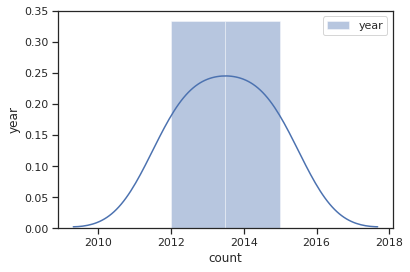

In [22]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set(style="ticks")

df10p = df6.toPandas()
df10p = df10p.dropna()

# Sort the dataframe by target
target_0 = df10p
# target_1 = df11p.loc[df11p['subreddit'] == topic2]

ax = sns.distplot(target_0[['year']], label='year', hist=True, rug=False, kde=True)

ax.set(xlabel='count', ylabel='year')

plt.legend()